<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="# Case 2 - Pneumonia X-ray Image Analysis" data-toc-modified-id="Case-X.-Template-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case X. Template</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Modes-and-training" data-toc-modified-id="Modes-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modes and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 2 - Pneumonia X-ray Image Analysis
Samuel Räsänen, Arttu Sundell, Jari Putaansuu<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>
13.02.2020<br>

# Background

The aim of this Notebook is ...

# Tools

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import os
import shutil
import random
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, FalseNegatives,FalsePositives
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

Populating the interactive namespace from numpy and matplotlib


# Data and preparation

In [2]:
#Importin train dataset

norm_dir1 = "/kaggle/input/chestxray2017/chest_xray/train/NORMAL"
norm_dir2 = "/kaggle/input/chestxray2017/chest_xray/test/NORMAL"

sick_dir1 = "/kaggle/input/chestxray2017/chest_xray/train/PNEUMONIA"
sick_dir2 = "/kaggle/input/chestxray2017/chest_xray/test/PNEUMONIA"


In [3]:
#creating a pool directory and all the data subset directories
pool_dir = './pool'
testset = './test'
trainset = './train'
valset = './val'


allnewdirs=[pool_dir,trainset,valset, testset]
try:
    for d in allnewdirs:
        os.mkdir(d)
        os.mkdir(os.path.join(d, 'NORMAL'))
        os.mkdir(os.path.join(d, 'PNEUMONIA'))
except:
    pass

In [4]:
#shutil.rmtree(valset) #jos tarvii poistella syntyneitä kansioita

In [5]:
# list the filenames of normal images
normal_images1=[n for n in os.listdir(norm_dir1) if n.endswith(".jpeg")]
normal_images2=[n for n in os.listdir(norm_dir2) if n.endswith(".jpeg")]
no_normal_images1=len(normal_images1)
no_normal_images2=len(normal_images2)

#list the filenames of pneumoniaimages
pneumonia_images1 = [n for n in os.listdir(sick_dir1) if n.endswith(".jpeg")]
pneumonia_images2 = [n for n in os.listdir(sick_dir2) if n.endswith(".jpeg")]
no_pneumonia_images1=len(pneumonia_images1)
no_pneumonia_images2=len(pneumonia_images2)

print('normal images:', no_normal_images1,"+", no_normal_images2)
print('pneumonia images:', no_pneumonia_images1,"+",no_pneumonia_images2)

normal images: 1349 + 234
pneumonia images: 3883 + 390


In [6]:
#Copying normal imagesets 1& 2 into pool "NORMAL"
for fname in normal_images1:
    src = os.path.join(norm_dir1, fname)
    dst = os.path.join(pool_dir,'NORMAL', fname)
    shutil.copyfile(src,dst)
    
for fname in normal_images2:
    src = os.path.join(norm_dir2, fname)
    dst = os.path.join(pool_dir,'NORMAL', fname)
    shutil.copyfile(src,dst)
    
 #copying pneumonia imagesets 1& 2 into pool "PNEUMONIA"
for fname in pneumonia_images1:
    src = os.path.join(sick_dir1, fname)
    dst = os.path.join(pool_dir,'PNEUMONIA', fname)
    shutil.copyfile(src,dst)
    
for fname in pneumonia_images2:
    src = os.path.join(sick_dir2, fname)
    dst = os.path.join(pool_dir,'PNEUMONIA', fname)
    shutil.copyfile(src,dst)


In [7]:
#get filenames of normal and pneumonia images and shuffle for a more randomised train val and test set split
normal_images=normal_images1+normal_images2
pneumonia_images=pneumonia_images1+pneumonia_images2

random.shuffle(normal_images)
random.shuffle(pneumonia_images)


In [8]:
#The splittin for training, validation and test datasets for about 60:20:20 ratio
##trying to get similar fractions of normal and pneumonia pictures in all datasets


#Testset (in total of 1000 for reliable metrics)
##Normal images
for fname in normal_images[:300]:
    src = os.path.join(pool_dir,'NORMAL', fname)
    dst = os.path.join(testset,'NORMAL', fname)
    shutil.copyfile(src,dst)
    
##Pneumonia images    
for fname in pneumonia_images[:700]:
    src = os.path.join(pool_dir,'PNEUMONIA', fname)
    dst = os.path.join(testset,'PNEUMONIA', fname)
    shutil.copyfile(src,dst)

#-------------------------------------------------
##Valset (in total of 1000 for nice accuracy)
##Normal images
for fname in normal_images[301:601]:
    src = os.path.join(pool_dir,'NORMAL', fname)
    dst = os.path.join(valset,'NORMAL', fname)
    shutil.copyfile(src,dst)

##Pneumonia images    
for fname in pneumonia_images[701:1401]:
    src = os.path.join(pool_dir,'PNEUMONIA', fname)
    dst = os.path.join(valset,'PNEUMONIA', fname)
    shutil.copyfile(src,dst)
#---------------------------------------------------
##Trainset = the rest
##Normal images
for fname in normal_images[602:]:
    src = os.path.join(pool_dir,'NORMAL', fname)
    dst = os.path.join(trainset,'NORMAL', fname)
    shutil.copyfile(src,dst)

##Pneumonia images    
for fname in pneumonia_images[1402:]:
    src = os.path.join(pool_dir,'PNEUMONIA', fname)
    dst = os.path.join(trainset,'PNEUMONIA', fname)
    shutil.copyfile(src,dst)


# Image preprocessing

Different kind of images of the target are desirable where the "object" to be recognized appears in varying... There should be some data augmentation (flipped, rotated, squashed, and so on) introduced to the samples in the training set as it makes the model more generizable. For example, if by some luck every person in the picture had the chances indicating pneumonia on the left side of their lugns, or on the lower part of their lugns the model might learn that when theres something going on in a specific part of lugns it's pneumonia, and fail to recognize abnormalities in some other parts if it was later introduced to a picture having a change in some previoisly unseen part of lungs. Unless it appears only in certain parts of lugns. To make the learning harder for the model, some random horizontal and vertical flipping of the images could be introduced. But " Finally, in many of the application domains covered such as medical image analysis, the biases distancing the training data from the testing data are more complex than positional and transla- tional variances. erefore, the scope of where and when geometric transformations can be applied is relatively limited."....

https://www.researchgate.net/post/data_augmentation_techniques_for_medical_image
https://arxiv.org/pdf/1902.05655.pdf
https://www.researchgate.net/publication/334279066_A_survey_on_Image_Data_Augmentation_for_Deep_Learning


testset = './test'
trainset = './train'
valset = './val'


In [9]:
TS = (150, 150) # Variable for Image Target Size
BS = 16 # Variable for Image Batch Size

# Generate two Data Generators for data processing

# https://keras.io/preprocessing/image

traingen = ImageDataGenerator(rescale=1./255, # All images will be rescaled by 1./255
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=True) 
#-----------------------------------------------------------------------------------
devgen = ImageDataGenerator(rescale=1./255) # All images will be rescaled by 1./255

print('Training set:')
train_generator = traingen.flow_from_directory(
    #this is the target directory
    trainset,
    
    #All images will be resized to 150x150
    target_size = TS,
    
    #We read images in batches of 16
    batch_size = BS,

    #Create binary labels
    class_mode = 'binary')

#-----------------------------------------------------------------------------------
print('Validation set:')
dev_generator = devgen.flow_from_directory(
    valset,
    target_size = TS,
    batch_size = BS,
    shuffle = False, #no shuffle for validation
    class_mode = 'binary')

#-----------------------------------------------------------------------------------
print('Test set:')
test_generator = devgen.flow_from_directory(
    testset,
    target_size = TS,
    batch_size = BS,
    shuffle = False, #no shuffle for test
    class_mode = 'binary')

Training set:
Found 3852 images belonging to 2 classes.
Validation set:
Found 1000 images belonging to 2 classes.
Test set:
Found 1000 images belonging to 2 classes.


In [10]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
# Check for the generator output
i = 0
for data_batch, labels_batch in train_generator:
    print('data batch shape: ', data_batch.shape)
    print('labels batch shape: ', labels_batch.shape)
    i = i+1
    if i > 5:
        break

data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)


In [12]:
labels_batch

array([1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

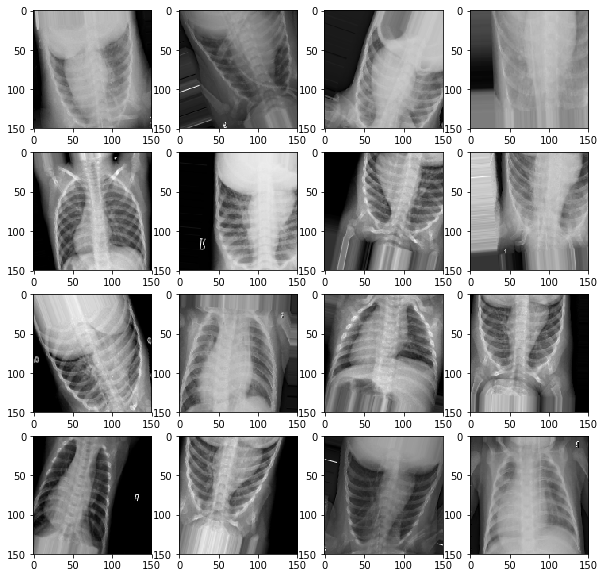

array([1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

In [13]:
# Check the first 16 images from the batch

figure(figsize = (10,10))
for i in range(16):
    subplot(4,4, i+1)
    imshow(data_batch[i])
show()

# Check the last labels batch

labels_batch

# Building the model

In [14]:
# Build a simple convolutional neural network (CNN)

model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

# Let's use slower learning rate than the default rate
# https://keras.io/optimizers
MetricsSet=['acc',FalseNegatives(),FalsePositives()]
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop (lr = 1e-4), metrics = MetricsSet )
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 16)        4

In [15]:
## Train the network with the training and validation data
# Reading all batches per epoch (steps_per_epoch = None) using all 4187 images
# modifying steps_per_epoch = 10 would result in reading only 10 batches per epoch (10x16 = 160 images per epoch)

# https://keras.io/models/sequential/#fit_generator

history = model.fit_generator(
    train_generator,
    steps_per_epoch = None,
    verbose = 1,
    epochs = 25,
    validation_data = dev_generator,
    validation_steps = None)

# save the model
model.save('case_2_run_1.h5')

Train for 241 steps, validate for 63 steps
Epoch 1/25
241/241 [==============================] - 73s 303ms/step - loss: 0.5750 - acc: 0.7443 - false_negatives: 10.0000 - false_positives: 975.0000 - val_loss: 0.6226 - val_acc: 0.7000 - val_false_negatives: 0.0000e+00 - val_false_positives: 300.0000
Epoch 2/25
241/241 [==============================] - 68s 282ms/step - loss: 0.5104 - acc: 0.7523 - false_negatives: 111.0000 - false_positives: 843.0000 - val_loss: 0.4743 - val_acc: 0.8210 - val_false_negatives: 170.0000 - val_false_positives: 9.0000
Epoch 3/25
241/241 [==============================] - 68s 282ms/step - loss: 0.4231 - acc: 0.8009 - false_negatives: 256.0000 - false_positives: 511.0000 - val_loss: 0.5266 - val_acc: 0.7130 - val_false_negatives: 287.0000 - val_false_positives: 0.0000e+00
Epoch 4/25
241/241 [==============================] - 67s 280ms/step - loss: 0.3754 - acc: 0.8333 - false_negatives: 256.0000 - false_positives: 386.0000 - val_loss: 0.3152 - val_acc: 0.8850 

# Results and Discussion

The following results were achieved ...

In [18]:
hh=history.history

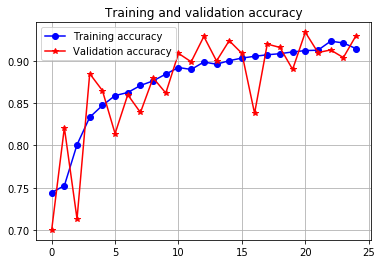

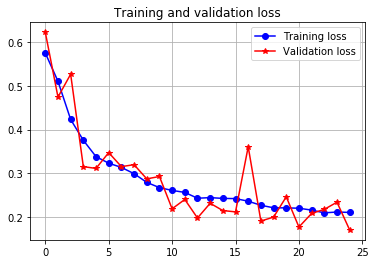

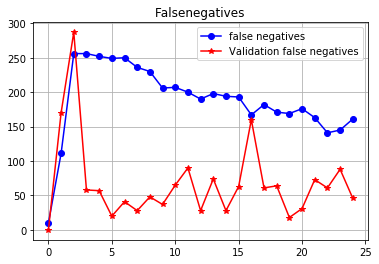

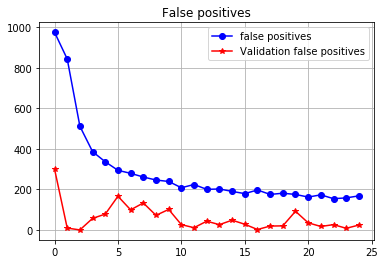

In [20]:
# Check the accuracy and loss graphs for the training done

acc = hh['acc']
val_acc = hh['val_acc']
loss = hh['loss']
val_loss = hh['val_loss']
fn=hh['false_negatives']
vfn=hh['val_false_negatives']
fp=hh['false_positives']
vfp=hh['val_false_positives']
epochs = range(len(acc))

#Accuracy

plot(epochs, acc, 'bo-', label = "Training accuracy")
plot(epochs, val_acc, 'r*-', label = "Validation accuracy")
title('Training and validation accuracy')
grid()
legend()

#Loss

figure()
plot(epochs, loss, 'bo-', label = "Training loss")
plot(epochs, val_loss, 'r*-', label = "Validation loss")
title('Training and validation loss')
grid()
legend()

#Falsenegatives
figure()
plot(epochs, fn, 'bo-', label = "false negatives")
plot(epochs, vfn, 'r*-', label = "Validation false negatives")
title('Falsenegatives')
grid()
legend()

#False positives
figure()
plot(epochs, fp, 'bo-', label = "false positives")
plot(epochs, vfp, 'r*-', label = "Validation false positives")
title('False positives')
grid()
legend()

show()

In [21]:
# Find the labels

labels = dev_generator.classes

# Predict the results

predicted = model.predict_generator(dev_generator).flatten()

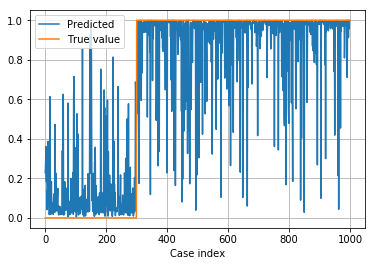

In [22]:
# Plot the predicted and true labels

plt.plot (predicted, label = 'Predicted')
plt.plot (labels, label = 'True value')
plt.legend()
plt.xlabel ('Case index')
plt.grid()

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/

In [37]:
# Create a confusion matrix and calculate classification report for observations

print ('Confusion matrix: ')
cm = confusion_matrix(labels, predicted > 0.5)
print(cm)

cr = classification_report(labels, predicted > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

Confusion matrix: 
[[271  29]
 [ 33 667]]
               precision    recall  f1-score   support

   Normal (0)       0.86      0.92      0.89       300
Pneumonia (1)       0.96      0.93      0.95       700

     accuracy                           0.93      1000
    macro avg       0.91      0.93      0.92      1000
 weighted avg       0.93      0.93      0.93      1000



Accuracy calculated from the testing set = 0.930
Confusion matrix:



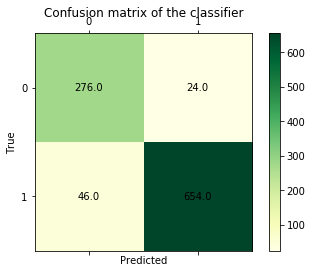

In [28]:
accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
print("Accuracy calculated from the testing set = %.3f" % (accuracy))


print("Confusion matrix:\n")

fig = plt.figure() 

ax = fig.add_subplot(111) 

cax = ax.matshow(cm, cmap='YlGn') 

plt.title('Confusion matrix of the classifier') 

fig.colorbar(cax) 

#ax.set_xticklabels([''] + labels) 

#ax.set_yticklabels([''] + labels) 

plt.xlabel('Predicted') 

plt.ylabel('True') 

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()

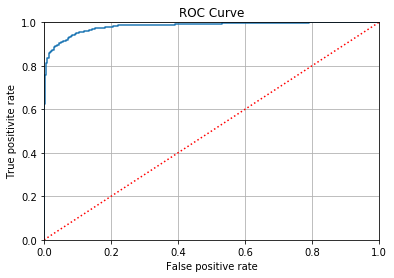

In [29]:
# Calculate the ROC curve for further analysis

fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)

# Show the ROC curve plot

plt.plot (fpr, tpr)
plt.plot ([0, 1], [0, 1], 'r:')
plt.xlabel('False positive rate')
plt.ylabel('True positivite rate')
plt.title('ROC Curve')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()

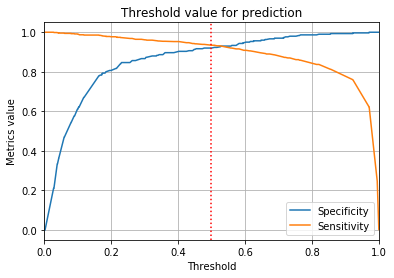

In [30]:
# Find the best threshold for predictions

plt.plot(thresholds, 1 - fpr, label = 'Specificity')
plt.plot(thresholds, tpr, label = 'Sensitivity')
plt.axvline(0.5, color = 'red', linestyle = ':')
plt.xlim([0, 1])
plt.title('Threshold value for prediction')
plt.xlabel('Threshold')
plt.ylabel('Metrics value')
plt.legend()
plt.grid()


In [33]:
# Test the model accuracy with unseen test data (test_generator)

loss, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
#loss, acc = model2.evaluate(test_generator, steps=len(test_generator), verbose=1)
#loss, acc = model3.evaluate(test_generator, steps=len(test_generator), verbose=1)

63/63 [==============================] - 12s 192ms/step - loss: 0.1761 - acc: 0.9290 - false_negatives: 50.0000 - false_positives: 21.0000


ValueError: too many values to unpack (expected 2)

# Conclusions

Results made Samuel very ankgry